In [442]:
# Importando bibliotecas necessárias
import json
import numpy as np
import pandas as pd
import math
import sys
import os
import seaborn as sns
from numpy import zeros, array, asarray
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot
from matplotlib.pyplot import figure
from keras import metrics
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Activation, SimpleRNN
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [443]:
# Parametros modificados com frequência
debug = True
col_switch = ('summary', 'description')
xcol = col_switch[1]
docs_length = 'mean'
embedding_size = 50
z_score_threshold = 1
z_score_times = 2
lstm = True
dense_layers = False
dropout = True
num_categories = 4
limit_rows = True
cat_row_limit = 5000

In [444]:
# Arquivos das embeddings pré-treinadas
emb_file = dict()
emb_file[50] = './drive/MyDrive/ColabNotebooks/glove.6B.50d.txt'
emb_file[100] = './drive/MyDrive/ColabNotebooks/glove.6B.100d.txt'
emb_file[200] = './drive/MyDrive/ColabNotebooks/glove.6B.200d.txt'
emb_file[300] = './drive/MyDrive/ColabNotebooks/glove.6B.300d.txt'

In [445]:
# Abrindo dados como ndarray
data = []
path = './drive/MyDrive/ColabNotebooks/data/'
filelist = os.listdir(path)
filelist.sort()
# filelist = ['EVL_lab_clean.json']
repo_num = len(filelist)
print("Numero de repositorios: {}".format(repo_num))
for filename in filelist:
  with open(path + filename, 'r') as file:
    repo = json.load(file)
    data += repo
ndata = pd.DataFrame(data).values
pd_data = pd.DataFrame(data)
if debug:
  print(ndata)
  print(ndata.shape)

Numero de repositorios: 70
[['14161' 'ABU'
  list(['contrib-graphic remove body attribute from example.json'])
  list(["i know it's a core model attribute but it's not actually used in this component so it's a little misleading to list it in example.json"])
  '1800' 96.0]
 ['14436' 'ABU' list(['remove readme.pdf'])
  list(["this pdf is hugely and no longer req'd"]) '120' 97.0]
 ['14201' 'ABU' list(['unused color variables'])
  list(['remove from colors.less file or use in theme']) '1800' 97.0]
 ...
 ['10102' 'ZONG' list(["andi's work in"]) nan '3589200' nan]
 ['10010' 'ZONG'
  list(['create diagrams showing the zong modules and their dependencies'])
  nan '9600' nan]
 ['10009' 'ZONG' list(['write guide how to build zong']) nan '11400' nan]]
(97274, 6)


In [446]:
# Convertendo o timespent para float
pd_data['timespent'] = pd_data.timespent.astype(float)

In [447]:
# Removendo linhas com description null
bool_series = pd.notnull(pd_data['description']) 

pd_data = pd_data[bool_series]

In [448]:
# Removendo linhas com summary null
bool_series = pd.notnull(pd_data['summary']) 

pd_data = pd_data[bool_series]

In [449]:
# Removendo linhas com timespent null
bool_series = pd.notnull(pd_data['timespent']) 

pd_data = pd_data[bool_series]

In [450]:
pd_data

,id,project,summary,description,timespent,alpha
0,14161,ABU,[contrib-graphic remove body attribute from ex...,[i know it's a core model attribute but it's n...,1800.0,96.0
1,14436,ABU,[remove readme.pdf],[this pdf is hugely and no longer req'd],120.0,97.0
2,14201,ABU,[unused color variables],[remove from colors.less file or use in theme],1800.0,97.0
3,11902,ABU,[review outstanding pull requests],[as per call on sven adding on aniket's behalf],93600.0,97.0
4,15601,ABU,[remove istrackable from adaptmodel.js],[as it isn't actually implemented also remove ...,900.0,98.0
...,...,...,...,...,...,...
97249,10500,UTILS,[clean up],[merge into move all tests to own project test],3600.0,100.0
97250,10400,UTILS,[java se implementation for xmlreader and xmlw...,[create java se implementations for the platfo...,7200.0,100.0
97251,10322,UTILS,[clean up utils],[get rid of integrate them into as far as poss...,14400.0,100.0
97252,10321,UTILS,[java se dependencies in own project],[clean the utils projects from java se depende...,8100.0,100.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


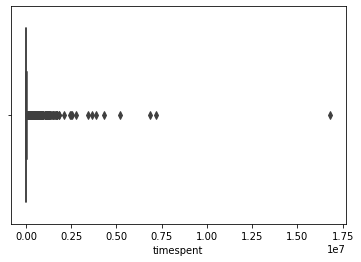

In [451]:
sns.boxplot(pd_data['timespent'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


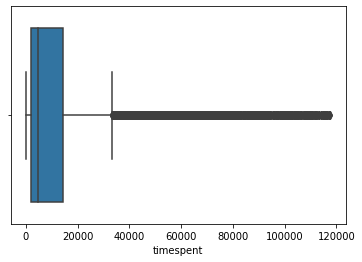

In [452]:
def my_zscore(x):
  return ((x - x.mean())/x.std())

cara =  my_zscore(pd_data['timespent'])
df_sem_outlier_z = pd.DataFrame(
    pd_data[(abs(cara) < z_score_threshold)])
sns.boxplot(df_sem_outlier_z['timespent'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


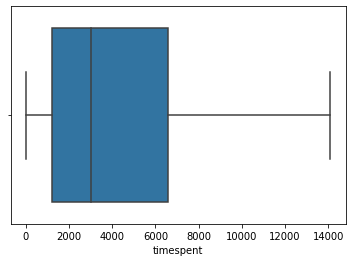

In [453]:
# Aplicando o z score mais vezes para remover mais os outliers
for i in range(z_score_times):
  # z_score_threshold = 1
  cara =  my_zscore(df_sem_outlier_z['timespent'])
  df_sem_outlier_z = pd.DataFrame(
      df_sem_outlier_z[(abs(cara) < z_score_threshold)])

sns.boxplot(df_sem_outlier_z['timespent'])

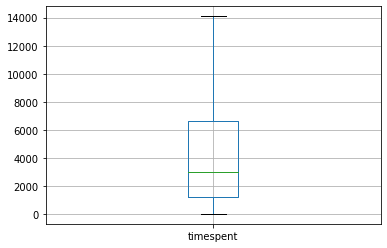

In [454]:
df_sem_outlier_z.boxplot('timespent')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5186b2fa50>]],
      dtype=object)

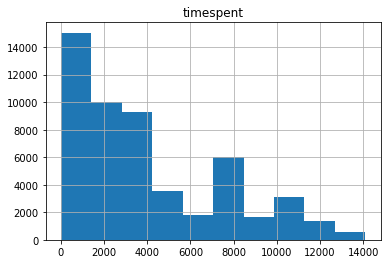

In [455]:
df_sem_outlier_z.hist('timespent')

In [456]:
df_sem_outlier_z

,id,project,summary,description,timespent,alpha
0,14161,ABU,[contrib-graphic remove body attribute from ex...,[i know it's a core model attribute but it's n...,1800.0,96.0
1,14436,ABU,[remove readme.pdf],[this pdf is hugely and no longer req'd],120.0,97.0
2,14201,ABU,[unused color variables],[remove from colors.less file or use in theme],1800.0,97.0
4,15601,ABU,[remove istrackable from adaptmodel.js],[as it isn't actually implemented also remove ...,900.0,98.0
5,15400,ABU,[scorm.setversion is never called if you don't...,[if you leave the advancedsettings property ou...,1200.0,98.0
...,...,...,...,...,...,...
97248,10501,UTILS,[build server broken],[build server does not work any more restart a...,1890.0,100.0
97249,10500,UTILS,[clean up],[merge into move all tests to own project test],3600.0,100.0
97250,10400,UTILS,[java se implementation for xmlreader and xmlw...,[create java se implementations for the platfo...,7200.0,100.0
97252,10321,UTILS,[java se dependencies in own project],[clean the utils projects from java se depende...,8100.0,100.0


In [457]:
data = df_sem_outlier_z

In [458]:
data

,id,project,summary,description,timespent,alpha
0,14161,ABU,[contrib-graphic remove body attribute from ex...,[i know it's a core model attribute but it's n...,1800.0,96.0
1,14436,ABU,[remove readme.pdf],[this pdf is hugely and no longer req'd],120.0,97.0
2,14201,ABU,[unused color variables],[remove from colors.less file or use in theme],1800.0,97.0
4,15601,ABU,[remove istrackable from adaptmodel.js],[as it isn't actually implemented also remove ...,900.0,98.0
5,15400,ABU,[scorm.setversion is never called if you don't...,[if you leave the advancedsettings property ou...,1200.0,98.0
...,...,...,...,...,...,...
97248,10501,UTILS,[build server broken],[build server does not work any more restart a...,1890.0,100.0
97249,10500,UTILS,[clean up],[merge into move all tests to own project test],3600.0,100.0
97250,10400,UTILS,[java se implementation for xmlreader and xmlw...,[create java se implementations for the platfo...,7200.0,100.0
97252,10321,UTILS,[java se dependencies in own project],[clean the utils projects from java se depende...,8100.0,100.0


In [459]:
uniq = data['timespent'].unique()
uniq.sort(axis=0)
print(uniq)
print(len(uniq))

[6.0000e+00 1.2000e+01 1.5000e+01 3.0000e+01 3.6000e+01 6.0000e+01
 1.0800e+02 1.2000e+02 1.8000e+02 2.4000e+02 2.8800e+02 3.0000e+02
 3.0400e+02 3.6000e+02 4.2000e+02 4.5000e+02 4.6800e+02 4.8000e+02
 5.4000e+02 6.0000e+02 6.1200e+02 6.4800e+02 6.6000e+02 7.2000e+02
 7.8000e+02 8.2800e+02 8.4000e+02 9.0000e+02 9.1200e+02 9.1500e+02
 9.6000e+02 1.0080e+03 1.0200e+03 1.0800e+03 1.1400e+03 1.1880e+03
 1.2000e+03 1.2120e+03 1.2600e+03 1.3200e+03 1.3800e+03 1.4400e+03
 1.4880e+03 1.5000e+03 1.5600e+03 1.6200e+03 1.6800e+03 1.6920e+03
 1.7400e+03 1.8000e+03 1.8150e+03 1.8300e+03 1.8600e+03 1.8900e+03
 1.9200e+03 1.9800e+03 2.0400e+03 2.0520e+03 2.0880e+03 2.1000e+03
 2.1600e+03 2.2200e+03 2.2680e+03 2.2800e+03 2.3400e+03 2.4000e+03
 2.4120e+03 2.4480e+03 2.4600e+03 2.5200e+03 2.5800e+03 2.6280e+03
 2.6400e+03 2.7000e+03 2.7150e+03 2.7600e+03 2.8200e+03 2.8800e+03
 2.9400e+03 3.0000e+03 3.0120e+03 3.0480e+03 3.0600e+03 3.1200e+03
 3.1680e+03 3.1800e+03 3.2400e+03 3.2760e+03 3.3000e+03 3.3120

In [460]:
data['timespent'].describe()

count    52378.000000
mean      4085.923307
std       3355.006353
min          6.000000
25%       1200.000000
50%       3000.000000
75%       6600.000000
max      14100.000000
Name: timespent, dtype: float64

In [461]:
# Categorizando os dados
#data['timespent'] = data.timespent.ge(1200).astype(int)
categories = list(range(0, num_categories))
data['timespent_cat'], bins = pd.cut(data['timespent'], bins=len(categories), include_lowest=True, labels=categories, retbins=True)

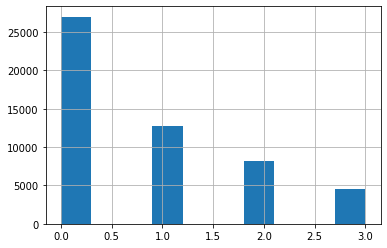

In [462]:
data['timespent_cat'].hist()

In [463]:
# Função para descrever os intervalos de cada categoria
def describe_intervals(data):
  for i in range(len(categories)):
    print("Cat {}".format(i))
    print("From {} - To {}".format(bins[i], bins[i+1]))
    bool_series = data['timespent_cat'].eq(i)
    cat = data[bool_series] 
    min = cat['timespent'].min()
    max = cat['timespent'].max()
    print("Min: {} - Max: {}".format(min, max))
    count = cat['timespent'].count()
    print("Count: {}".format(count))

In [464]:
describe_intervals(data)

Cat 0
From -8.094 - To 3529.5
Min: 6.0 - Max: 3480.0
Count: 26997
Cat 1
From 3529.5 - To 7053.0
Min: 3540.0 - Max: 7020.0
Count: 12711
Cat 2
From 7053.0 - To 10576.5
Min: 7080.0 - Max: 10560.0
Count: 8123
Cat 3
From 10576.5 - To 14100.0
Min: 10620.0 - Max: 14100.0
Count: 4547


Cat 0
From -8.094 - To 3529.5
Min: 6.0 - Max: 3480.0
Count: 5000
Cat 1
From 3529.5 - To 7053.0
Min: 3540.0 - Max: 7020.0
Count: 5000
Cat 2
From 7053.0 - To 10576.5
Min: 7080.0 - Max: 10512.0
Count: 5000
Cat 3
From 10576.5 - To 14100.0
Min: 10620.0 - Max: 14100.0
Count: 4547


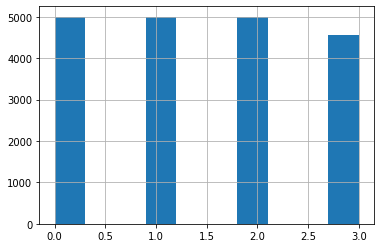

In [465]:
if limit_rows:
  data = data.groupby('timespent_cat').head(cat_row_limit)
  describe_intervals(data)
  data['timespent_cat'].hist()

In [465]:
data

In [466]:
# Obtendo todas as palavras das description para serem treinadas
all_text = []
for description in data['description'].values:
  for des_str in description:
    all_text.append(des_str.split())

for summary in data['summary'].values:
  for sum_str in summary:
    all_text.append(sum_str.split())

if debug:
  print(len(all_text))
  # print(all_text)

67063


In [467]:
# Definindo o modelo de word embeddings
emb_model = Word2Vec(all_text, min_count=3, size=embedding_size)
# Resumo do modelo
if debug:
  print(emb_model)
words = list(emb_model.wv.vocab)
if debug:
  print(words)

vocab_size = len(words) + 1
if debug:
  print(vocab_size)
  print(emb_model.wv.vectors)

Word2Vec(vocab=9485, size=50, alpha=0.025)
['i', 'know', "it's", 'a', 'core', 'model', 'attribute', 'but', 'not', 'actually', 'used', 'in', 'this', 'component', 'so', 'little', 'misleading', 'to', 'list', 'it', 'pdf', 'is', 'and', 'no', 'longer', 'remove', 'from', 'file', 'or', 'use', 'theme', 'as', "isn't", 'implemented', 'also', 'reference', 'if', 'you', 'leave', 'the', 'property', 'out', 'of', 'config.json', 'never', 'called', 'whilst', "doesn't", 'cause', 'problems', 'for', 'most', 'will', 'trigger', 'version', 'explicitly', 'set', 'watch', 'task', 'that', 'runs', 'do', 'grunt', 'dev', 'changes', 'then', 'copy', 'into', 'build', 'when', 'changed', 'saved', 'replicate', 'run', 'make', 'change', 'save', 'observe', 'command', 'line', 'says', 'src', 'course', 'tasks', 'are', 'go', 'has', 'been', 'updated', 'on', 'page', 'any', 'options', 'an', 'mcq', 'selected', 'ends', 'up', 'being', 'read', 'times', 'once', 'before', 'twice', 'after', 'indicated', 'completion', 'state', "shouldn't", 

In [468]:
# Brincando com o modelo
print(emb_model.wv.similarity('java', 'code'))
emb_model.wv.most_similar(positive=['staging'], topn=10)


0.4458625


[('oss', 0.8975627422332764),
 ('shibboleth.net', 0.8861986994743347),
 ('qa', 0.8760492205619812),
 ('amp', 0.8734822273254395),
 ('lint', 0.8694623708724976),
 ('ee', 0.867803156375885),
 ('cd', 0.8668195605278015),
 ('safari', 0.8668085932731628),
 ('tom', 0.8661269545555115),
 ('galaxy', 0.8657747507095337)]

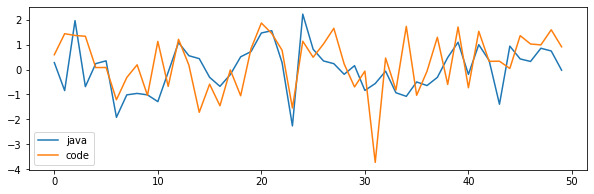

In [469]:
# Comparando vetores de palavras
pyplot.figure(figsize=(10,3))
w1 = 'java'
w2 = 'code'
w1v = emb_model.wv.get_vector(w1)
w2v = emb_model.wv.get_vector(w2)
pyplot.plot(w1v, label=w1)
pyplot.plot(w2v, label=w2)
pyplot.legend()
pyplot.show()

In [470]:
# Obtendo a lista de docs concatenando summary + description
docs = []
for i in range(len(data)):
  summ = data['summary'].values[i]
  desc = data['description'].values[i]
  sentence_agg = ""
  for sum_item in summ:
    sentence_agg += sum_item
    sentence_agg += " "
  for desc_item in desc:
    sentence_agg += desc_item
    sentence_agg += " "
  sentence_agg = sentence_agg.rstrip()
  docs.append(sentence_agg)
for i in range(10):
  print(docs[i])
print(len(docs))

contrib-graphic remove body attribute from example.json i know it's a core model attribute but it's not actually used in this component so it's a little misleading to list it in example.json
remove readme.pdf this pdf is hugely and no longer req'd
unused color variables remove from colors.less file or use in theme
remove istrackable from adaptmodel.js as it isn't actually implemented also remove reference to it from
scorm.setversion is never called if you don't include advancedsettings if you leave the advancedsettings property out of config.json scorm.setversion is never called whilst this doesn't cause problems for most lmses it will trigger problems in saba and plateau if the version is not explicitly set
grunt task runner dev task does not copy json changes to the build the watch task that runs if you do grunt dev will watch for changes to config.json but then copy config.json into the build when this file is changed saved to replicate run grunt dev make a change to and save the fi

In [471]:
docs_len = []
for doc in docs:
  docs_len.append(len(doc.split()))
print(docs_len[0:10])

[31, 10, 11, 15, 45, 83, 39, 13, 12, 12]


In [472]:
df_sem_outlier_z = data

In [473]:
df_sem_outlier_z['docs_lens'] = docs_len

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [474]:
df_sem_outlier_z

,id,project,summary,description,timespent,alpha,timespent_cat,docs_lens
0,14161,ABU,[contrib-graphic remove body attribute from ex...,[i know it's a core model attribute but it's n...,1800.0,96.0,0,31
1,14436,ABU,[remove readme.pdf],[this pdf is hugely and no longer req'd],120.0,97.0,0,10
2,14201,ABU,[unused color variables],[remove from colors.less file or use in theme],1800.0,97.0,0,11
4,15601,ABU,[remove istrackable from adaptmodel.js],[as it isn't actually implemented also remove ...,900.0,98.0,0,15
5,15400,ABU,[scorm.setversion is never called if you don't...,[if you leave the advancedsettings property ou...,1200.0,98.0,0,45
...,...,...,...,...,...,...,...,...
97170,10205,GANTT,[slack time support],[for issues render a slack time line],10800.0,100.0,3,10
97171,10204,GANTT,[fix rendering of issues],[when issue has parents from different branche...,10800.0,100.0,3,27
97187,11306,ZONG,[acquire certificate for code signing],"[we want to sign our jar files, for applets an...",10800.0,99.0,3,45
97225,10307,ZONG,[integrate converter project],[integrate the converter project from zong],11700.0,100.0,3,9


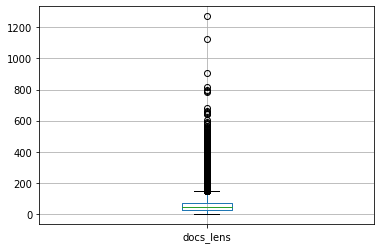

In [475]:
df_sem_outlier_z.boxplot('docs_lens')

In [476]:
# Tamanho máximo dos docs
max_length_des = 0
if docs_length == 'mean':
  max_length_des = int(df_sem_outlier_z['docs_lens'].mean())
  if debug:
    print(max_length_des)
elif docs_length == 'min':
  max_length_des = int(df_sem_outlier_z['docs_lens'].min())
  if debug:
    print(max_length_des)
else:
  for desc in data[xcol].values:
    sentence_size = 0
    for sentence in desc:
      sentence_size += len(sentence.split())
    if sentence_size > max_length_des:
      max_length_des = sentence_size
  if debug:
    print(max_length_des)

60


In [477]:
# Carregando as embeddings pré-treinadas
embeddings_index = dict()
f = open(emb_file.get(embedding_size))
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400001 word vectors.


In [478]:
# Criando a matriz de embeddings
embedding_matrix = zeros((vocab_size, embedding_size))
for i, word in enumerate(words):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [479]:
doc_encoded = zeros((max_length_des))
print(doc_encoded.shape)

(60,)


In [480]:
len(docs)

19547

In [481]:
# Codificando os documentos
padded_docs = zeros((len(docs), max_length_des))
for i, doc in enumerate(docs):
  doc_word_list = doc.split()
  doc_encoded = zeros((max_length_des))
  for j, word in enumerate(doc_word_list):
    if j < max_length_des:
      if word in emb_model.wv.vocab:
        doc_encoded[j] = emb_model.wv.vocab[word].index + 1
  padded_docs[i] = doc_encoded
padded_docs     

array([[   0.,   96., 1355., ...,    0.,    0.,    0.],
       [  96.,    0.,    9., ...,    0.,    0.,    0.],
       [1446., 1381., 1230., ...,    0.,    0.,    0.],
       ...,
       [3646., 1213.,    8., ...,    0.,    0.,    0.],
       [2317., 2166.,  136., ...,    0.,    0.,    0.],
       [1012.,  269.,   19., ...,    0.,    0.,    0.]])

In [482]:
print(padded_docs.shape)

(19547, 60)


In [483]:
# Particionando conjunto de teste e treino para avaliação
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(padded_docs, data['timespent_cat'].values.codes, test_size=0.2, random_state=1212)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(15637, 60)
(3910, 60)
(15637,)
(3910,)


15637

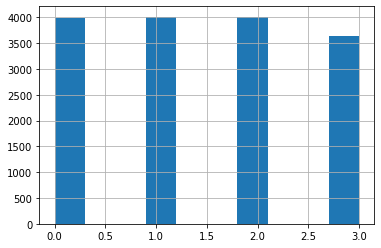

In [484]:
ytp = pd.Series(y_train)
ytp.hist()
len(y_train)

3910

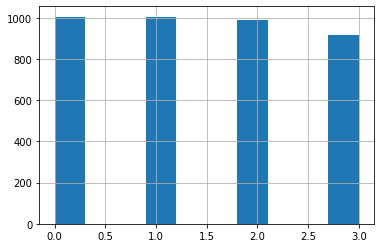

In [485]:
ytt = pd.Series(y_test)
ytt.hist()
len(y_test)

In [506]:
# Definindo o modelo
def compile_model():
  model = Sequential()
  e = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=max_length_des, trainable=False)
  model.add(e)
  if lstm:
    model.add(Bidirectional(LSTM(max_length_des * 2)))
    if dropout:
      model.add(Dropout(0.7))
  else:
    model.add(Flatten())
    if dropout:
      model.add(Dropout(0.1))
  if dense_layers:
    model.add(Dense(200, activation='relu'))
    if dropout:  
      model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
    if dropout:
      model.add(Dropout(0.1))
    # model.add(Dense(16, activation='relu'))
    # if dropout:
    #   model.add(Dropout(0.2))
    # model.add(Dense(4, activation='relu'))
    # if dropout:
    #   model.add(Dropout(0.1))
  #model.add(Dense(1, activation='sigmoid'))
  model.add(Dense(len(categories), activation='softmax'))
  # Compilando o modelo
  #opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  #model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
  # Resumo do modelo
  print(model.input_shape)
  print(model.summary())
  return model

In [487]:
vocab_size

9486

Fold 1 


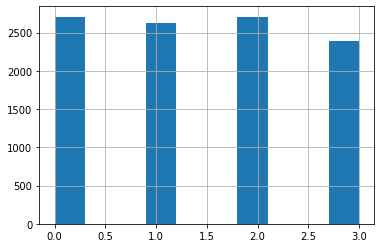

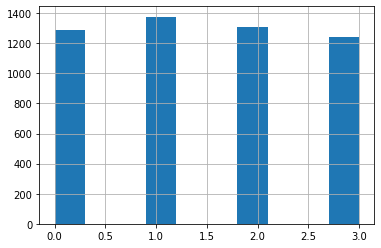

(None, 60)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 50)            474300    
                                                                 
 bidirectional (Bidirectiona  (None, 240)              164160    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 4)                 964       
                                                                 
Total params: 639,424
Trainable params: 165,124
Non-trainable params: 474,300
_________________________________________________________________
None
Epoch 1/20
652/652 [==============================] - 71s 103ms/step - loss: 1.3981 - accuracy

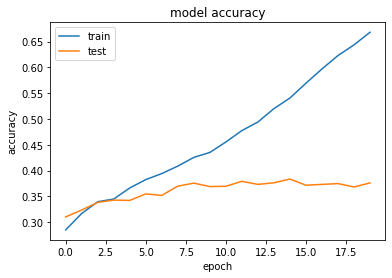

Fold 2 


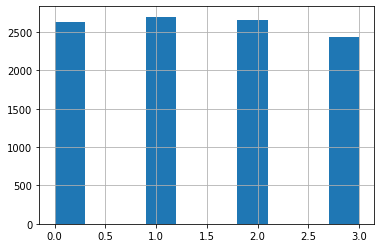

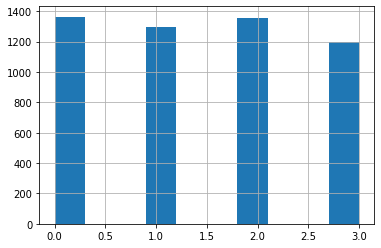

(None, 60)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 50)            474300    
                                                                 
 bidirectional_1 (Bidirectio  (None, 240)              164160    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 240)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 964       
                                                                 
Total params: 639,424
Trainable params: 165,124
Non-trainable params: 474,300
_________________________________________________________________
None
Epoch 1/20
652/652 [==============================] - 71s 103ms/step - loss: 1.3976 - accura

KeyboardInterrupt: ignored

In [507]:
from keras.backend import clear_session
clear_session()
# Treinando o modelo

from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
foldn = 1
acc_hist = []
acc_val_hist = []
models = []
for train_index, val_index in kf.split(x_train):
 
  x_train_new = x_train[train_index]
  y_train_new = y_train[train_index]

  x_val = x_train[val_index]
  y_val = y_train[val_index]

  print("Fold {} ".format(foldn))
  foldn += 1

  ytn = pd.Series(y_train_new)
  ytn.hist()
  pyplot.show()

  yv = pd.Series(y_val)
  yv.hist()
  pyplot.show()

  model = compile_model()
  history = model.fit(x_train_new, y_train_new, epochs=20, batch_size=16, validation_data=(x_val, y_val), verbose=1)

  models.append(model)
  pyplot.plot(history.history['accuracy'])
  pyplot.plot(history.history['val_accuracy'])
  pyplot.title('model accuracy')
  pyplot.ylabel('accuracy')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'test'], loc='upper left')
  pyplot.show()

(None, 60)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 50)            474300    
                                                                 
 bidirectional (Bidirectiona  (None, 120)              53280     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 4)                 484       
                                                                 
Total params: 528,064
Trainable params: 53,764
Non-trainable params: 474,300
_________________________________________________________________
None
Epoch 1/50
367/367 [==============================] - 28s 65ms/step - loss: 1.4047 - accuracy: 

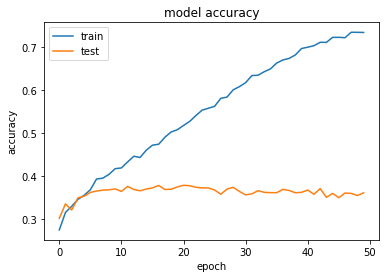

In [489]:
from keras.backend import clear_session
clear_session()
# Treinando o modelo

model = compile_model()
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.25, verbose=1)

models.append(model)
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [490]:
# Avaliando os modelos
for i, model in enumerate(models):
  print("MODELO {}".format(i))
  print('Treino')
  loss, metric = model.evaluate(x_train, y_train)
  print('Loss: {}'.format(loss))
  print('Metric: {}'.format(metric))
  print('Test')
  loss, metric = model.evaluate(x_test, y_test)
  print('Loss: {}'.format(loss))
  print('Metric: {}'.format(metric))

MODELO 0
Treino
489/489 [==============================] - 8s 16ms/step - loss: 1.0862 - accuracy: 0.5293
Loss: 1.0862022638320923
Metric: 0.5293214917182922
Test
123/123 [==============================] - 2s 15ms/step - loss: 1.4229 - accuracy: 0.3775
Loss: 1.4229050874710083
Metric: 0.37749361991882324
MODELO 1
Treino
489/489 [==============================] - 8s 16ms/step - loss: 1.0891 - accuracy: 0.5416
Loss: 1.0891252756118774
Metric: 0.5416000485420227
Test
123/123 [==============================] - 2s 15ms/step - loss: 1.4222 - accuracy: 0.3719
Loss: 1.4221588373184204
Metric: 0.37186700105667114
MODELO 2
Treino
489/489 [==============================] - 8s 15ms/step - loss: 1.0593 - accuracy: 0.5462
Loss: 1.0592693090438843
Metric: 0.5462045073509216
Test
123/123 [==============================] - 2s 15ms/step - loss: 1.4224 - accuracy: 0.3806
Loss: 1.42237389087677
Metric: 0.3805626630783081
MODELO 3
Treino
489/489 [==============================] - 7s 15ms/step - loss: 0.883

In [491]:
# Fazendo e avaliando previsões com o melhor modelo
model = models[1]
predictions = model.predict(x_test)
print(predictions[0])
pred_class = []
for pred in predictions:
  pred_class.append(np.argmax(pred))

[0.3256183  0.35711503 0.21095906 0.10630757]


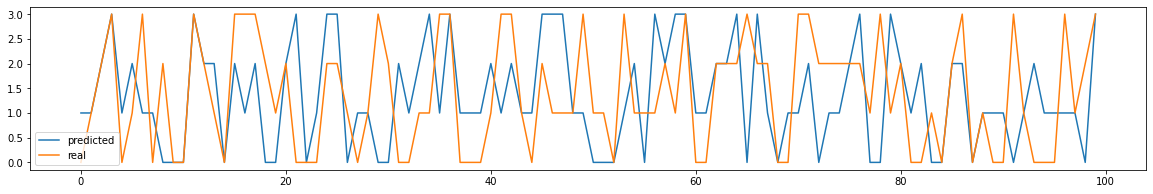

In [492]:
pred_to_plot = pred_class
psize = 100
pyplot.figure(figsize=(20,3))
pyplot.plot(pred_to_plot[0:psize], label='predicted')
pyplot.plot(y_test[0:psize], label='real')
pyplot.legend()
pyplot.show()

[Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2'), Text(0, 3.5, '3')]

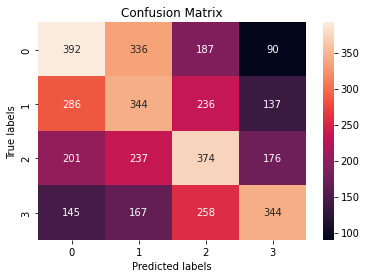

In [493]:
import seaborn as sns
import matplotlib.pyplot as plt    
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_class) 

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(categories) 
ax.yaxis.set_ticklabels(categories)

In [494]:
# # Calculando mmre and mae para validação
# from sklearn.metrics import mean_absolute_error

# def mre(actual, pred):
#   actual += 1
#   pred += 1
#   mre = (abs(actual - pred)) / actual
#   return mre

# def mmre(y, pred):
#   sum = 0.0
#   for i, actual in enumerate(y):
#     sum += mre(actual, pred[i])
#   mmre = (sum / (len(y))) 
#   return mmre

# print("MMRE: {}".format(mmre(y_test, pred_class)))
# print("MAE: {}".format(mean_absolute_error(y_test, pred_class)))

In [495]:
# Old figure of confusion matrix
# fig = pyplot.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(cm)
# pyplot.title('Confusion matrix of the classifier')
# fig.colorbar(cax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
# pyplot.xlabel('Predicted')
# pyplot.ylabel('True')
# pyplot.show()

In [496]:
# pyplot.plot(history.history['mae'])
# pyplot.plot(history.history['val_mae'])
# pyplot.title('model accuracy')
# pyplot.ylabel('mae')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'test'], loc='upper left')
# pyplot.show()

In [497]:
# # Primeiro Quartil
# Q1 = pd_data['timespent'].quantile(0.25)
# print("Q1: {}".format(Q1))
# # Segundo Quartil
# Q2 = pd_data['timespent'].quantile(0.50)
# print("Q2: {}".format(Q2))
# # Terceiro Quartil
# Q3 = pd_data['timespent'].quantile(0.75)
# print("Q3: {}".format(Q3))
# # Amplitude Interquartil
# IQR = Q3 - Q1
# print("IQR: {}".format(IQR))
# # Limite Superior
# LI = Q1 - (1.5 * IQR)
# print("LI: {}".format(LI))
# # Limite Inferior
# LS = Q3 + (1.5 * IQR)
# print("LS: {}".format(LS))

In [498]:
# df_sem_outlier = pd.DataFrame(
#     pd_data[(
#         (pd_data['timespent'] >= LI) 
#         & (pd_data['timespent'] <= LS)
#     )])

# sns.boxplot(df_sem_outlier['timespent'])

In [499]:
# for pred in predictions:
#     if pred != 1089.0886 and pred != 1089.0885:
#       print(pred)

In [500]:
# # Visualizando o word embedding
# X = emb_model[emb_model.wv.vocab]
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)
# fig, ax = pyplot.subplots()
# ax.scatter(result[:, 0], result[:, 1])
# xlim1 = -0.200
# xlim2 = -0.125
# ylim1 = -0.02
# ylim2 = 0.02
# limits = False

# words = list(emb_model.wv.vocab)
# for i, word in enumerate(words):
#   x = result[i, 0]
#   y = result[i, 1]
#   if limits:
#     if x >= xlim1 and x <= xlim2 and y >= ylim1 and y <= ylim2: 
# 	    ax.annotate(word, xy=(x, y))
#   else:
#     ax.annotate(word, xy=(x, y))

# if limits:
#   ax.set_xlim(xlim1, xlim2)
#   ax.set_ylim(ylim1, ylim2)

In [501]:
# prepare tokenizer
# t = Tokenizer()
# t.fit_on_texts(summary_list)
# vocab_size = len(t.word_index) + 1
# print(vocab_size)

In [502]:
# integer encode the documents
# encoded_docs = t.texts_to_sequences(summary_list)
# print(encoded_docs)

In [503]:
# padded_docs = pad_sequences(encoded_docs, maxlen=max_summary_length, padding='post')
# print(padded_docs)

In [504]:
# ss = StandardScaler()
# sclWord = ss.fit(emb_model.wv.vectors)
# vectors_normalized = sclWord.transform(vocab_dict.values())

# vectors_list = []
# for word in emb_model.wv.vocab:
#   vectors_list.append(emb_model.wv.get_vector(word))

# print(type(emb_model.wv.vocab))
# embeddings_index = dict()
# for i, word in enumerate(list(emb_model.wv.vocab)[0:10]):
#   print(emb_model.wv.vectors[i])
#   print(vectors_list[i])
	#embeddings_index[word] = vectors_normalized[i]

In [505]:
# count = 0
# for cara in embedding_matrix:
#   if cara[0] == 0:
#     count+=1
# print(count)